<a href="https://colab.research.google.com/github/ZykinaViktoriya/Python_for_analytics/blob/main/Final_project_A_B_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('/content/drive/MyDrive/результаты А_B - cookie_cats 2.csv')
df.sample(15)

,userid,version,sum_gamerounds,retention_1,retention_7
62396,6913205,gate_40,2,0,0
55419,6146097,gate_40,111,1,0
3534,390288,gate_30,6,1,0
54607,6061097,gate_40,81,1,1
9379,1030990,gate_30,104,1,0
13662,1514013,gate_40,14,0,1
68237,7563671,gate_40,105,1,0
41113,4548888,gate_30,1,0,0
16588,1846601,gate_40,93,1,0
79484,8800373,gate_40,37,0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  int64 
 4   retention_7     90189 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 3.4+ MB


In [4]:
df.describe()

,userid,sum_gamerounds,retention_1,retention_7
count,9.018900e+04,90189.000000,90189.000000,90189.000000
mean,4.998412e+06,51.872457,0.445210,0.186065
std,2.883286e+06,195.050858,0.496992,0.389161
min,1.160000e+02,0.000000,0.000000,0.000000
25%,2.512230e+06,5.000000,0.000000,0.000000
50%,4.995815e+06,16.000000,0.000000,0.000000
75%,7.496452e+06,51.000000,1.000000,0.000000
max,9.999861e+06,49854.000000,1.000000,1.000000


In [5]:
df.groupby('version')['userid'].count()

version
gate_30    44700
gate_40    45489
Name: userid, dtype: int64

Построим график распределения игроков,сыгравших от0 до 100 раундов

Text(0, 0.5, 'User Count')

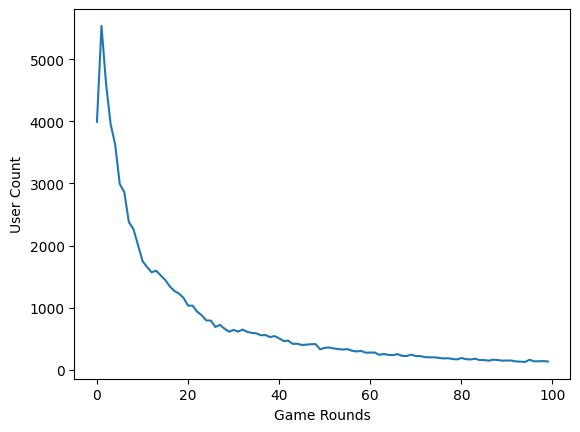

In [6]:
%matplotlib inline

plot_df = df.groupby('sum_gamerounds')['userid'].count()

ax = plot_df.head(n=100).plot(x="sum_gamerounds", y="userid")
ax.set_xlabel("Game Rounds")
ax.set_ylabel("User Count")

На графике мы видим,что некоторые игроки устанавливают,но так и не играют в игру. Поэтому нам необходимо проанализировать процент возврата пользователей на следующий день после установки.

Процент пользователей, вернувшихся на следующий день после установки

In [7]:
df['retention_1'].sum() / df['retention_1'].count()

0.4452095044850259

Мы видим,что почти половина пользователей возвращается на следующий день

In [8]:
df.groupby('version')['retention_1'].sum() / df.groupby('version')['userid'].count()

version
gate_30    0.448188
gate_40    0.442283
dtype: float64

Мы видим,что процент возврата на следующий день немного ниже после установки порога в 40 уровней(44,2%), в отличие от предыдущей версии,где порог был в 30 уровней (44,8%). Проверим каждую из групп

<Axes: ylabel='Density'>

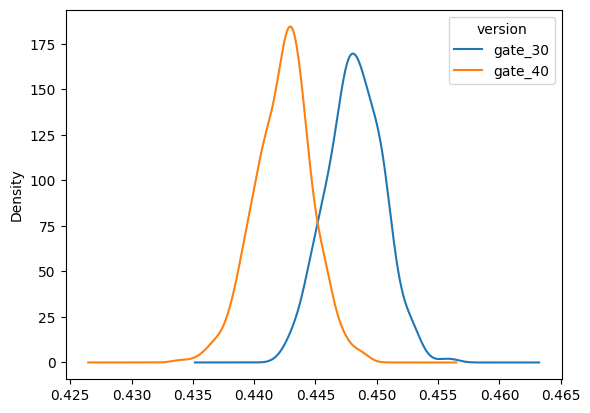

In [9]:
boot_1d = []
for i in range(500):
    boot_mean = df.sample(frac=1, replace=True).groupby('version')['retention_1'].mean()
    boot_1d.append(boot_mean)

boot_1d = pd.DataFrame(boot_1d)

boot_1d.plot(kind='kde')

Text(0.5, 0, '% difference in means')

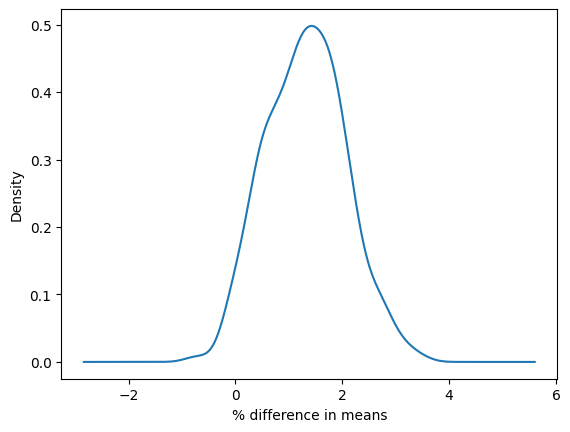

In [14]:
# Adding a column with the % difference between the two AB-groups
boot_1d['diff'] = (boot_1d['gate_30'] - boot_1d['gate_40']) /  boot_1d['gate_40'] * 100

# Ploting the bootstrap % difference
ax = boot_1d['diff'].plot(kind = 'kde')
ax.set_xlabel("% difference in means")

Проверим, если вернуть порог в 30 уровней, повысит ли это ретеншн 1 дня

In [11]:
prob = (boot_1d['diff'] > 0).sum() / len(boot_1d)

# Pretty printing the probability
'{:.1%}'.format(prob)

'96.6%'

Мы видим,что процент ретеншна при пороге в 30 уровней становится намного выше, но игроки, играющие один день могут не дойти до 30 уровня вовсе. Поэтому нам нужно выяснить,какой процент игроков возвращаеется в игру спустя неделю.

In [12]:
df.groupby('version')['retention_7'].sum() / df.groupby('version')['userid'].count()

version
gate_30    0.190201
gate_40    0.182000
dtype: float64

Как и в прошлом сравнении,мы видим, что процент вернувшихся в игру при пороге в 40 уровней ниже(18,2%),чем при пороге в 30 уровней (19%).Также мы видим,что через неделю играет значительно меньше игроков,чем на следующий день.

'100.0%'

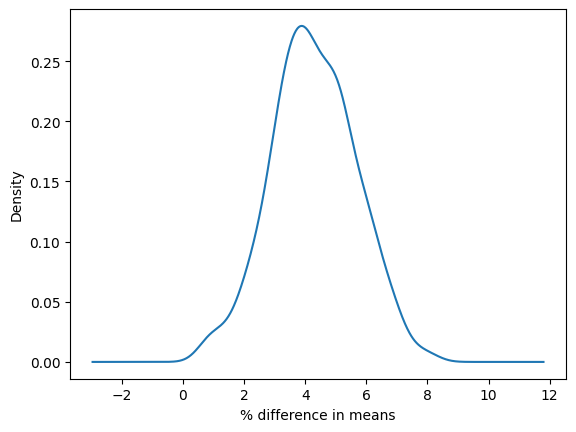

In [13]:
boot_7d = []
for i in range(500):
    boot_mean = df.sample(frac=1, replace=True).groupby('version')['retention_7'].mean()
    boot_7d.append(boot_mean)

boot_7d = pd.DataFrame(boot_7d)

boot_7d['diff'] = (boot_7d['gate_30'] - boot_7d['gate_40']) /  boot_7d['gate_30'] * 100

ax = boot_7d['diff'].plot(kind = 'kde')
ax.set_xlabel("% difference in means")

prob = (boot_7d['diff'] > 0).sum() / len(boot_7d)

'{:.1%}'.format(prob)

По результатам тестирования,мы видим,что возврат на следующий день и спустя 7 дней выше при пороге в 30 уровней, чем при пороге в 40 уровней. Поэтому для лучшего удержания клиентов необходимо вернуть порог в 30 уровней.